### Convolutional Neural Networks

Building a CNN using `Tensoflow`'s integrated `keras` API

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
%matplotlib inline

### Data preperation

The images inclued in the data/cats-and-dots directory are a random subset of the full cat and dog data set from the following Kaggle competition: https://www.kaggle.com/c/dogs-vs-cats/data.

This data set contains 50,000 images of dogs and cats. We will be selecting small random sample of this to create,
 - 1000 training set
 - 200 validation set
 - 100 test set

In [2]:
# Organze data into train, valid, test dirs
os.chdir('data/dogs-vs-cats')
if os.path.isdir('train/dog') is False:
    os.makedirs('train/dog')
    os.makedirs('train/cat')

    os.makedirs('valid/dog')
    os.makedirs('valid/cat')

    os.makedirs('test/dog')
    os.makedirs('test/cat')

    for c in random.sample(glob.glob('population/cat*'), 500):
        shutil.move(c, 'train/cat')
    for c in random.sample(glob.glob('population/dog*'), 500):
        shutil.move(c, 'train/dog')

    for c in random.sample(glob.glob('population/cat*'), 100):
        shutil.move(c, 'valid/cat')
    for c in random.sample(glob.glob('population/dog*'), 100):
        shutil.move(c, 'valid/dog')

    for c in random.sample(glob.glob('population/cat*'), 50):
        shutil.move(c, 'test/cat')
    for c in random.sample(glob.glob('population/dog*'), 50):
        shutil.move(c, 'test/dog')
        
os.chdir('../../')

In [3]:
train_path = 'data/dogs-vs-cats/train'
valid_path = 'data/dogs-vs-cats/valid'
test_path = 'data/dogs-vs-cats/test'

### Preprocess the data
 - Identify dog and cat classes
 - Reshape the images to `(224,224)`
 - Make size 10 batches
 - `shuffle = False` for test set

In [4]:
train_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory = train_path, target_size = (224,224), classes = ['cat', 'dog'], batch_size = 10)
valid_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory = valid_path, target_size = (224,224), classes = ['cat', 'dog'], batch_size = 10)
test_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory = test_path, target_size = (224,224), classes = ['cat', 'dog'], batch_size = 10, shuffle = False)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [5]:
imgs, labels = next(train_batches)

In [6]:
# This function plots the size 10 batch images
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize = (20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

This is what a training batch of size 10 looks like.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

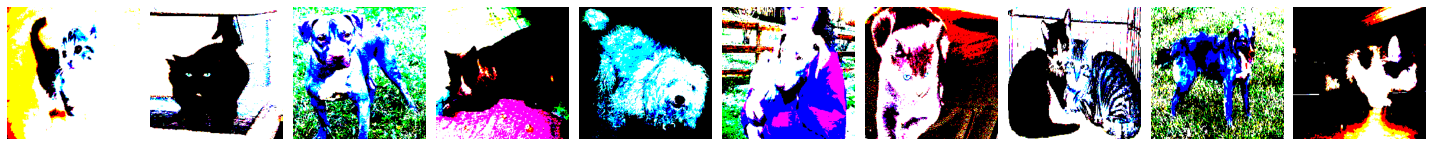

[[1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]


In [7]:
plotImages(imgs)
print(labels)

### Build and train a CNN
 - `Conv2D` - Standard convolutional layer that takes image data.
 - `padding = 'same'` - Does not reduce the image size after convolutions.
 - `MaxPool2D` - Cut image size by 2

In [8]:
model = Sequential([
    Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', 
           padding = 'same', input_shape = (224,224,3)),
    MaxPool2D(pool_size = (2,2), strides = 2),
    Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', 
           padding = 'same'),
    MaxPool2D(pool_size = (2,2), strides = 2),
    Flatten(),
    Dense(units = 2, activation = 'softmax')
])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 200704)            0         
                                                                 
 dense (Dense)               (None, 2)                 4

In [10]:
model.compile(optimizer = Adam(learning_rate = 0.0001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

Since we have only 2 categories, it it possible to use `binary_crossentropy` with the last layer as `Dense(units = 1, activation = 'sigmoid')`.

`train_batches` is a generator containing train data, batch size and labels all together. So in `model.fit` we only need to assign `x = train_batches`.

### Training the model

In [12]:
from tensorflow.keras.models import load_model

try:
    model = load_model('models/cat-vs-dog-CNN.model.h5')
except:   
    model.fit(x = train_batches, 
              validation_data = valid_batches, 
              epochs = 10, 
              verbose = 2)

Epoch 1/10
100/100 - 48s - loss: 16.7258 - accuracy: 0.5620 - val_loss: 14.9158 - val_accuracy: 0.5350 - 48s/epoch - 483ms/step
Epoch 2/10
100/100 - 46s - loss: 2.3534 - accuracy: 0.7660 - val_loss: 4.3989 - val_accuracy: 0.5700 - 46s/epoch - 456ms/step
Epoch 3/10
100/100 - 50s - loss: 0.3019 - accuracy: 0.9210 - val_loss: 1.9919 - val_accuracy: 0.6650 - 50s/epoch - 504ms/step
Epoch 4/10
100/100 - 52s - loss: 0.0926 - accuracy: 0.9730 - val_loss: 2.6028 - val_accuracy: 0.5850 - 52s/epoch - 515ms/step
Epoch 5/10
100/100 - 56s - loss: 0.0197 - accuracy: 0.9950 - val_loss: 2.2255 - val_accuracy: 0.6100 - 56s/epoch - 560ms/step
Epoch 6/10
100/100 - 56s - loss: 0.0050 - accuracy: 1.0000 - val_loss: 1.9107 - val_accuracy: 0.6500 - 56s/epoch - 565ms/step
Epoch 7/10
100/100 - 55s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 1.9164 - val_accuracy: 0.6300 - 55s/epoch - 552ms/step
Epoch 8/10
100/100 - 51s - loss: 7.2518e-04 - accuracy: 1.0000 - val_loss: 1.9083 - val_accuracy: 0.6400 - 51s/epoch

### Saving the model

In [13]:
if os.path.isfile('models/cat-vs-dog-CNN.model.h5') is False:
    model.save('models/cat-vs-dog-CNN.model.h5')

In [14]:
print(model.history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


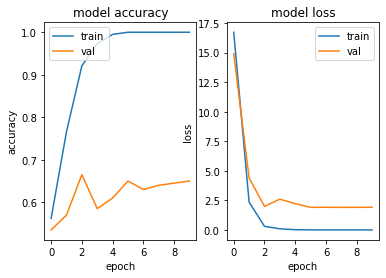

In [15]:
plt.subplot(1, 2, 1)
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

After the training we see that `accuracy: 1.0000` and `val_accuracy: 0.6900`, sugesting an overfitting in the model.

Even if this is the case, we will be moving forword with inference using the test set. It should give the same accuracy as we saw on validation set. 

### Predict

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

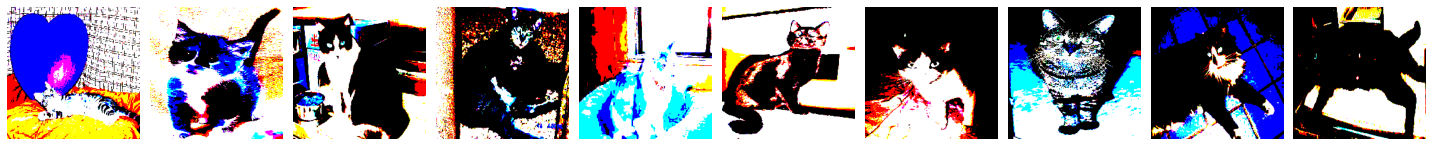

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [16]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [17]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [18]:
predictions = model.predict(x = test_batches, verbose = 0)

In [19]:
np.round(predictions)

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.

In [20]:
cm = confusion_matrix(y_true = test_batches.classes, 
                      y_pred = np.argmax(predictions, axis = -1))

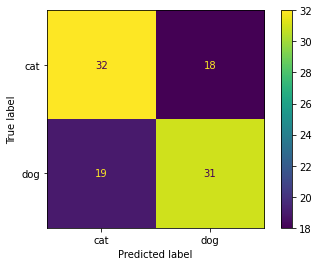

In [21]:
disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                              display_labels = test_batches.class_indices)
disp.plot()
plt.show()

### Conclution of this Notebook

 - This was a vary basic CNN model.
 - Larger training accuracy and smaller validation accuracy tells us an overfitting problem. 
 - It continues to get better and better at fitting the data that it sees (training data) while getting worse and worse at fitting the data that it does not see (validation data).
 - Test dataset also confirms this.
 - To avoid this we could improve our model with larger training set or more dense model.
 - Or we can fine-tune a pre-trained model to learn our dataset.